# Setup

In [ ]:
#!pip install tfa-nightly
#!pip install --user tensorflow==2.2.0-rc3

In [ ]:
## Downloading dataset to have it locally
#!pip install -q kaggle
#!mkdir ~/.kaggle 
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json
#!kaggle competitions download -c 'gan-getting-started'

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

2022-10-22 14:35:36.757013: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-10-22 14:35:36.757225: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Device: grpc://10.0.0.2:8470


2022-10-22 14:35:43.265802: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-22 14:35:43.269276: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-10-22 14:35:43.269318: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-22 14:35:43.269394: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (223791a53486): /proc/driver/nvidia/version does not exist
2022-10-22 14:35:43.273452: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8
2.4.1


# Load Dataset and Data Augmentation

In [10]:
# GCS_PATH = 'gs://kds-016646640abae494983957950b023cda4df83b370c3afc13bc5e0f5b'
GCS_PATH = KaggleDatasets().get_gcs_path('gan-getting-started')
OLD_GCS_PATH = 'gs://kds-3a22fef5730896bd0354f6152a1a49c186661079d15403a6ffb0ff8c'
if (GCS_PATH != OLD_GCS_PATH):
    print('Use this as GCS PATH:')
    print(GCS_PATH)
else:
    print('GCS PATH is the same')

GCS PATH is the same


In [11]:
import re

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

BATCH_SIZE =  4
EPOCHS_NUM = 30

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)


## local storage
# MONET_FILENAMES = tf.io.gfile.glob('./data/monet_tfrec/*.tfrec')
# print('Monet TFRecord Files:', len(MONET_FILENAMES))

# PHOTO_FILENAMES = tf.io.gfile.glob('./data/photo_tfrec/*.tfrec')
# print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


2022-10-22 14:35:49.722856: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-10-22 14:35:49.808679: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [12]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [13]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

def data_augment(image):
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    if p_crop > .5:
        image = tf.image.resize(image, [286, 286]) #resizing to 286 x 286 x 3
        image = tf.image.random_crop(image, size=[256, 256, 3]) # randomly cropping to 256 x 256 x 3
        if p_crop > .9:
            image = tf.image.resize(image, [300, 300])
            image = tf.image.random_crop(image, size=[256, 256, 3])
    
    if p_rotate > .9:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .7:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
        ## random mirroring
    if p_spatial > .6:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        if p_spatial > .9:
            image = tf.image.transpose(image)
    
    return image

def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):

    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)
    
    if augment:
        monet_ds = monet_ds.map(augment, num_parallel_calls=AUTO)
        photo_ds = photo_ds.map(augment, num_parallel_calls=AUTO)
        
    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
    if shuffle:
        monet_ds = monet_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    monet_ds = monet_ds.cache()
    photo_ds = photo_ds.cache()
    monet_ds = monet_ds.prefetch(AUTO)
    photo_ds = photo_ds.prefetch(AUTO)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds, monet_ds, photo_ds

In [14]:
#monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
#photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)
AUTO = tf.data.experimental.AUTOTUNE
full_dataset, monet_ds, photo_ds = get_gan_dataset(MONET_FILENAMES, PHOTO_FILENAMES, augment=data_augment, repeat=True, shuffle=True, batch_size=BATCH_SIZE)

In [15]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

#example_monet = load_image('/content/data/monet_jpg/000c1e3bff.jpg')
#example_photo = load_image('/content/data/photo_jpg/00068bc07f.jpg')

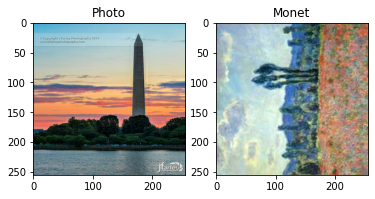

In [16]:
# check the dataset
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

# Generator

In [17]:
OUTPUT_CHANNELS = 3
KERNEL_SIZE = 8

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0.0, 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [18]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0.0, 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    # result.add(layers.ReLU())
    result.add(layers.LeakyReLU())

    return result

In [19]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, KERNEL_SIZE, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128,KERNEL_SIZE), # (bs, 64, 64, 128)
        downsample(256,KERNEL_SIZE), # (bs, 32, 32, 256)
        downsample(512,KERNEL_SIZE), # (bs, 16, 16, 512)
        downsample(512,KERNEL_SIZE), # (bs, 8, 8, 512)
        downsample(512,KERNEL_SIZE), # (bs, 4, 4, 512)
        downsample(512,KERNEL_SIZE), # (bs, 2, 2, 512)
        downsample(512,KERNEL_SIZE), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, KERNEL_SIZE, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, KERNEL_SIZE, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, KERNEL_SIZE, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, KERNEL_SIZE), # (bs, 16, 16, 1024)
        upsample(256, KERNEL_SIZE), # (bs, 32, 32, 512)
        upsample(128, KERNEL_SIZE), # (bs, 64, 64, 256)
        upsample(64, KERNEL_SIZE), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0.0, 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, KERNEL_SIZE,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

# Discriminator

In [20]:
def Discriminator():
    initializer = tf.random_normal_initializer(0.0, 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, KERNEL_SIZE, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, KERNEL_SIZE)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, KERNEL_SIZE)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, KERNEL_SIZE, strides=2,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, KERNEL_SIZE, strides=2,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [21]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

### Model Print

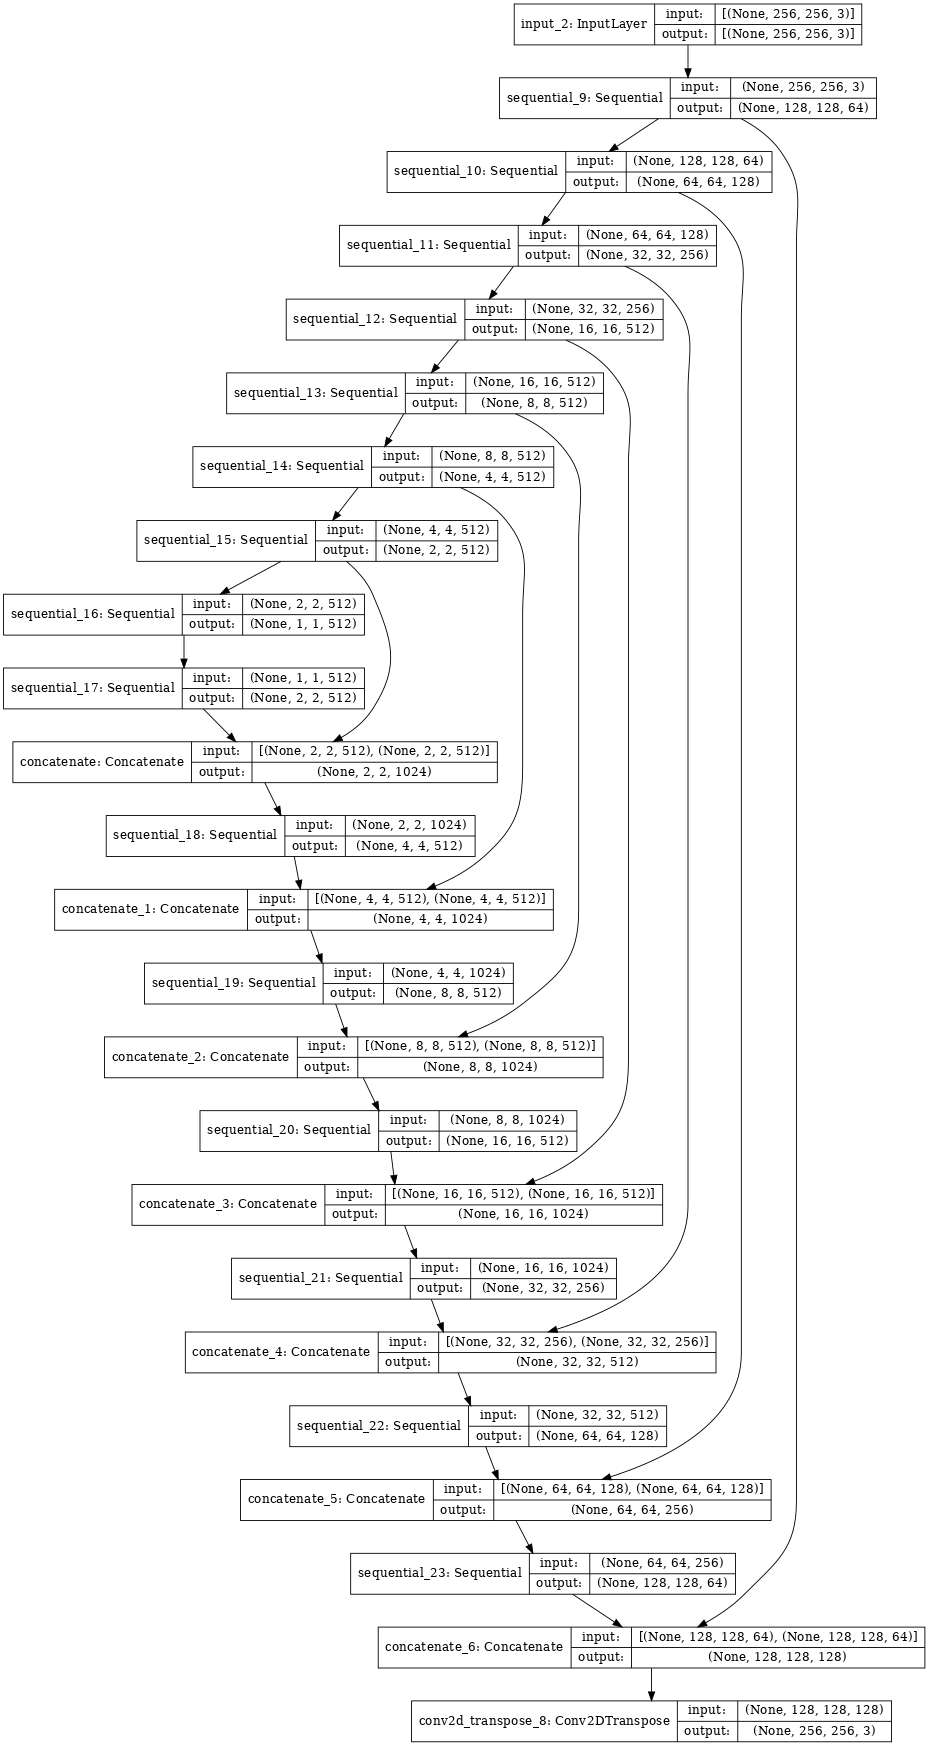

In [17]:
# generator_g = Generator()
tf.keras.utils.plot_model(monet_generator, show_shapes=True, dpi=64)

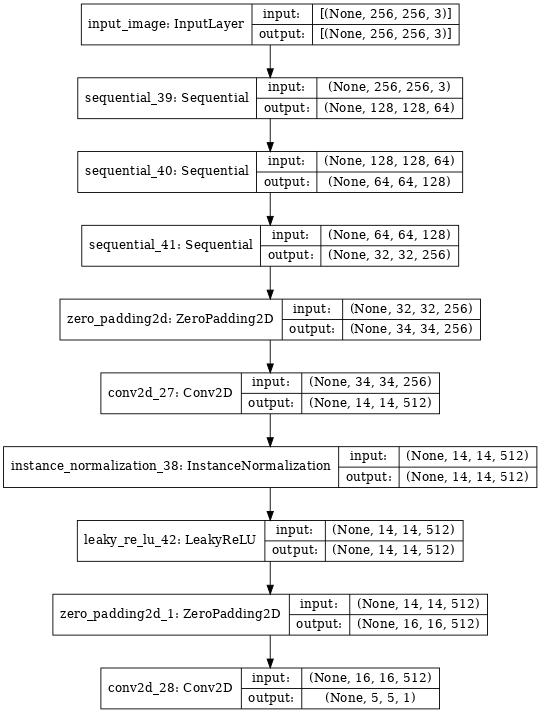

In [18]:
tf.keras.utils.plot_model(monet_discriminator, show_shapes=True, dpi=64)

In [19]:
monet_generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 128, 128, 64) 12288       input_2[0][0]                    
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 64, 64, 128)  524544      sequential_9[0][0]               
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 32, 32, 256)  2097664     sequential_10[0][0]              
______________________________________________________________________________________________

# CycleGAN

In [23]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=15, # 10
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Loss Functions


In [24]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [25]:
with strategy.scope():
    def generator_loss(generated):
        # difference between how the falsity of the image (as seen by the disc) and the actual value (how false it actually is, ones matrix)
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [26]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [27]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Training

In [28]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#     monet_discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=2e-4, momentum=0.5)
#     photo_discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=2e-4, momentum=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [29]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
# Load the model
# MODEL_PATH = '../input/model-k3/model_kernel3.hdf5'
# cycle_gan_model.built = True
# cycle_gan_model.load_weights(MODEL_PATH)

In [30]:
TRAINING_MODE = True
SUBMIT = True
MODEL_NAME = 'model_8_30epochs.hdf5'
MODEL_PATH = '../input/model-30/' + MODEL_NAME

if TRAINING_MODE:
    cycle_gan_model.fit(
        full_dataset,
        #tf.data.Dataset.zip((monet_ds, photo_ds)),
        epochs=30,
        steps_per_epoch=(max(n_monet_samples, n_photo_samples)//BATCH_SIZE)
    )
    print('Saving the model')
    cycle_gan_model.save_weights('./' + MODEL_NAME)
else: # load the model
    cycle_gan_model.built = True
    cycle_gan_model.load_weights(MODEL_PATH)
    print('Model loaded: ' + MODEL_NAME)

Epoch 1/30
1759/1759 [==============================] - 679s 324ms/step - monet_gen_loss: 4.2455 - photo_gen_loss: 4.1985 - monet_disc_loss: 0.6016 - photo_disc_loss: 0.6270
Epoch 2/30
1759/1759 [==============================] - 570s 324ms/step - monet_gen_loss: 3.4305 - photo_gen_loss: 3.5028 - monet_disc_loss: 0.6008 - photo_disc_loss: 0.5932
Epoch 3/30
1759/1759 [==============================] - 570s 324ms/step - monet_gen_loss: 3.1610 - photo_gen_loss: 3.3191 - monet_disc_loss: 0.6156 - photo_disc_loss: 0.5828
Epoch 4/30
1759/1759 [==============================] - 570s 324ms/step - monet_gen_loss: 3.1243 - photo_gen_loss: 3.3288 - monet_disc_loss: 0.6081 - photo_disc_loss: 0.5677
Epoch 5/30
1759/1759 [==============================] - 569s 324ms/step - monet_gen_loss: 3.1396 - photo_gen_loss: 3.3466 - monet_disc_loss: 0.6154 - photo_disc_loss: 0.5677
Epoch 6/30
1759/1759 [==============================] - 569s 324ms/step - monet_gen_loss: 3.2512 - photo_gen_loss: 3.3769 - monet_

# Results

2022-10-22 19:24:00.195004: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 495997, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1666466640.191460929","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 495997, Output num: 0","grpc_status":3}


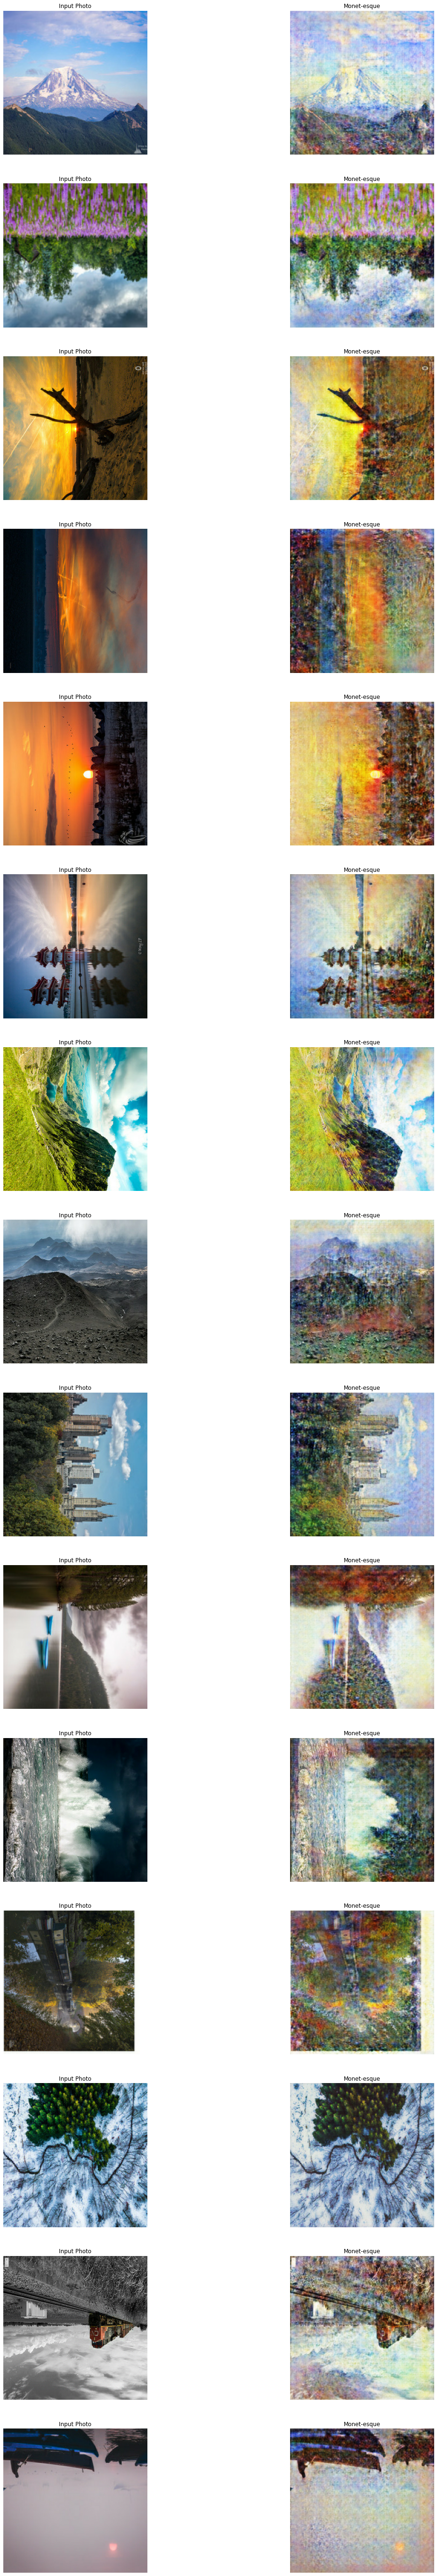

In [31]:
_, ax = plt.subplots(15, 2, figsize=(20, 100))
for i, img in enumerate(photo_ds.take(15)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Submission file

In [32]:
!ls ../input/output-images/

ls: cannot access '../input/output-images/': No such file or directory


In [33]:
import PIL
import shutil

! mkdir ./images
full_dataset, monet_ds, photo_ds = get_gan_dataset(MONET_FILENAMES, PHOTO_FILENAMES, augment=None, repeat=False, shuffle=False, batch_size=1)

In [ ]:
if SUBMIT:
    i = 1
    for img in photo_ds:
        prediction = monet_generator(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        im = PIL.Image.fromarray(prediction)
        im.save("./images/" + str(i) + ".jpg")
        if (i%100 == 0): print('Saved image ' + str(i))
        i += 1
    print('Done! Now zipping...')
    shutil.make_archive("./images", 'zip', "./images")
    !rm ./images/*
    !rm -d ./images

In [ ]:
# import shutil
# shutil.make_archive("./images", 'zip', "./images")
# shutil.make_archive("./images", 'zip', "../input/output-images/")
